In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

In [2]:
import glob
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [23]:
from scipy.linalg import get_blas_funcs

def blasmul(n, testing_duration=1):
    a = np.random.rand(n, n).astype('float32')
    b = np.random.rand(n, n).astype('float32')
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        gemm = get_blas_funcs("gemm", [a, b])
        c = gemm(1, a, b)
        print(c[0], np.dot(a, b)[0])
        #print(np.all(c == np.dot(a, b)))
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

blasmul(1024, 3)

[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369

0.27362548221241345

In [16]:
import torch

torch.set_num_threads(1)

def torchmul(n, testing_duration=1):
    a = torch.rand(n, n)
    b = torch.rand(n, n)
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        c = torch.mm(a, b)
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

torchmul(1024, 3)

[1024] 0.000002 x 1721918


1.7422450427032694e-06

In [11]:
def matmul(n, testing_duration=1):
    a = np.random.rand(n, n).astype('float32')
    b = np.random.rand(n, n).astype('float32')
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        c = np.dot(a, b)
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

matmul(1024, 3)

float32
[1024] 0.055771 x 54


0.055770551716839825

In [15]:
def run(binary, n, duration):
    print(f"running with n={n}... ", end="")
    result = !./$binary $n $duration
    print(result[0])
    return float(result[0].split()[0])

def benchmark(source, ns, duration=1):
    binary = source.split('.')[0] + '.benchmark'
    print(f"compiling {source}")
    !g++ -std=c++17 -O3 -ffast-math -funroll-loops -march=native -Wall benchmark.cc $source -o $binary
    return [run(binary, n, duration) for n in ns]

In [6]:
benchmark("v4.cc", [128, 256, 1024])

compiling v4.cc
running with n=128... 0.000171 x 5848
running with n=256... 0.001384 x 723
running with n=1024... 0.238639 x 5


[0.000171, 0.001384, 0.238639]

In [7]:
benchmark("v3.cc", [128, 256, 1024])

compiling v3.cc
v3.cc:17:23: optimized: loop vectorized using 32 byte vectors
running with n=128... 0.000504 x 1986
running with n=256... 0.003988 x 251
running with n=1024... 0.379358 x 3


[0.000504, 0.003988, 0.379358]

In [11]:
[matmul(n) for n in [128, 256, 1024]]

0.000053 x 18959
0.000292 x 3421
0.014097 x 71


[5.2751610252548984e-05, 0.0002923565836407155, 0.014097371571500537]

In [36]:
n = 1000
a = np.random.zeros(n, n).astype('int32')
b = np.random.rand(n, n).astype('int32')
start = time.time()
cnt = 0
while time.time() - start < 5:
    c = np.dot(a, b)
    cnt += 1
duration = (time.time() - start) / cnt
print(f'[{n}] {duration:6f} x {cnt}')

[1000] 3.007641 x 2


In [43]:
np.random.randint()

array([3, 0])

In [37]:
matmul(1000, 5)

[1000] 0.051945 x 97


0.05194487768350188

In [9]:
ns = [48*2, 48*5, 48*20, 2000]
benchmark("v4.cc", ns, 2)
benchmark("v5.cc", ns, 2)
[matmul(n, 2) for n in ns]

compiling v4.cc
running with n=96... 0.000059 x 34140
running with n=240... 0.001107 x 1807
running with n=960... 0.148153 x 14
running with n=2000... 1.617119 x 2
compiling v5.cc
running with n=96... 0.000059 x 33822
running with n=240... 0.001082 x 1849
running with n=960... 0.062717 x 32
running with n=2000... 0.532937 x 4
0.000077 x 26028
0.000901 x 2220
0.047909 x 42
0.409638 x 5


[7.68426616235466e-05,
 0.0009009764001176164,
 0.047909413065229146,
 0.4096375942230225]

In [23]:
#sources = sorted(glob.glob("v*.c*"))
#ns = [256, 256+128, 512, 512+256, 1024, 1024+256, 1024+512, 1024+512+256, 2048]
#ns = [128, 256, 512, 1024]

sources = ['v5.cc', 'v6.cc']
ns = [96 * i for i in range(1, 21)]

results = [benchmark(source, ns, 2) for source in sources]

compiling v5.cc
running with n=96... 0.000056 x 35853
running with n=192... 0.000564 x 3544
running with n=288... 0.001867 x 1072
running with n=384... 0.004346 x 461
running with n=480... 0.008054 x 249
running with n=576... 0.013751 x 146
running with n=672... 0.021356 x 94
running with n=768... 0.032623 x 62
running with n=864... 0.043853 x 46
running with n=960... 0.058874 x 34
running with n=1056... 0.079772 x 26
running with n=1152... 0.104404 x 20
running with n=1248... 0.131193 x 16
running with n=1344... 0.163595 x 13
running with n=1440... 0.195758 x 11
running with n=1536... 0.322031 x 7
running with n=1632... 0.282646 x 8
running with n=1728... 0.347328 x 6
running with n=1824... 0.401635 x 5
running with n=1920... 0.475576 x 5
compiling v6.cc
running with n=96... 0.000074 x 27040
running with n=192... 0.000615 x 3250
running with n=288... 0.001954 x 1024
running with n=384... 0.004365 x 459
running with n=480... 0.008191 x 245
running with n=576... 0.013925 x 144
running w

[96] 0.000074 x 26849
[192] 0.000470 x 4257
[288] 0.001470 x 1361
[384] 0.003285 x 609
[480] 0.006114 x 328
[576] 0.010308 x 195
[672] 0.016464 x 122
[768] 0.023658 x 85
[864] 0.033364 x 60
[960] 0.045965 x 44
[1056] 0.059994 x 34
[1152] 0.077512 x 26
[1248] 0.098478 x 21
[1344] 0.122740 x 17
[1440] 0.148788 x 14
[1536] 0.181200 x 12
[1632] 0.217583 x 10
[1728] 0.256233 x 8
[1824] 0.299285 x 7
[1920] 0.352238 x 6


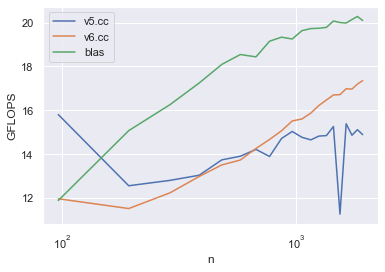

In [25]:
sources.append('blas')
results.append([matmul(n, 2) for n in ns])

for r in results:
    plt.plot(ns, [(n**3) / x / (10**9) for x, n in zip(r, ns)])

plt.xlabel('n')
plt.ylabel('GFLOPS')

plt.xscale('log')
plt.legend(sources)

In [56]:
ghz = 4.1
fma = 2
simd = 8
print(ghz * fma * simd)

65.6


In [ ]:
sources.append('blas')
ns = []

results.append([matmul(n) for n in ns])

for r in results:
    plt.plot(ns, [(n**3) / x / (10**9) for x, n in zip(r, ns)])